# Convex vs Non-Convex Loss Landscapes

This notebook illustrates the difference between a **convex** quadratic regression model and a **non-convex** two-layer neural network on a simple 1D regression task.

We will:

1. Generate a simple 1D dataset.
2. Fit a convex quadratic model.
3. Define a small 2-layer neural network (non-convex).
4. Visualize loss landscapes over a 2D parameter slice.
5. (Optionally) run gradient descent and project trajectories into the 2D slice.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

import os

fig_dir = "figs"
os.makedirs(fig_dir, exist_ok=True)
print("Saving figures to:", fig_dir)

Saving figures to: figs


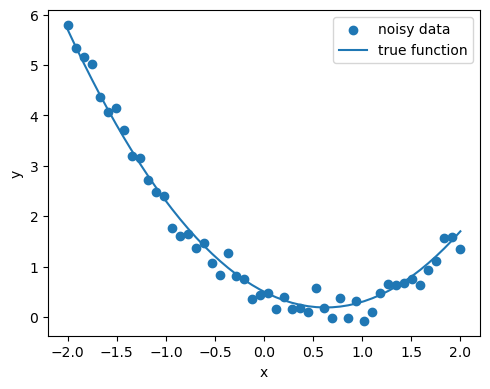

Saved figure: figs/convex_nonconvex_data.png


In [2]:
# 1. Generate a simple 1D regression dataset
N = 50
x = np.linspace(-2, 2, N)
true_w0, true_w1, true_w2 = 0.5, -1.0, 0.8  # ground truth quadratic
y_true = true_w0 + true_w1 * x + true_w2 * x**2
noise = 0.2 * np.random.randn(N)
y = y_true + noise

plt.figure(figsize=(5, 4))
plt.scatter(x, y, label="noisy data")
plt.plot(x, y_true, label="true function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.savefig("figs/convex_nonconvex_data.png", dpi=200)
plt.show()

print("Saved figure: figs/convex_nonconvex_data.png")

In [3]:
# 2. Convex quadratic model and loss

def quad_model(x, w):
    w0, w1, w2 = w
    return w0 + w1 * x + w2 * x**2

def mse_loss_quad(w, x, y):
    y_pred = quad_model(x, w)
    return 0.5 * np.mean((y_pred - y)**2)

# Least-squares fit via linear regression
X_design = np.stack([np.ones_like(x), x, x**2], axis=1)
w_ls, *_ = np.linalg.lstsq(X_design, y, rcond=None)
print("Least-squares quadratic weights:", w_ls)
print("MSE of LS solution:", mse_loss_quad(w_ls, x, y))

Least-squares quadratic weights: [ 0.41775557 -1.0289917   0.8267696 ]
MSE of LS solution: 0.015951460157072102


In [4]:
# 3. Two-layer NN (non-convex loss)

def nn_forward(x, params):
    # params = (W1, b1, W2, b2)
    W1, b1, W2, b2 = params
    x_col = x.reshape(-1, 1)
    h = np.tanh(x_col @ W1.T + b1)    # (N, H)
    y_pred = h @ W2.T + b2           # (N, 1)
    return y_pred.ravel()

def mse_loss_nn(params, x, y):
    y_pred = nn_forward(x, params)
    return 0.5 * np.mean((y_pred - y)**2)

# Initialize small network
H = 4
W1_init = 0.3 * np.random.randn(H, 1)
b1_init = 0.3 * np.random.randn(H)
W2_init = 0.3 * np.random.randn(1, H)
b2_init = np.array([0.0])

params_init = (W1_init, b1_init, W2_init, b2_init)
print("Initial NN loss:", mse_loss_nn(params_init, x, y))

Initial NN loss: 2.278505871013046


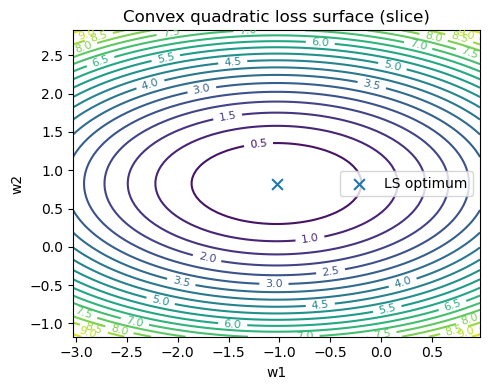

Saved figure: figs/convex_quad_loss_contours.png


In [5]:
# 4. Visualize convex loss surface over (w1, w2) with w0 fixed

w0_fixed = w_ls[0]
w1_vals = np.linspace(w_ls[1] - 2.0, w_ls[1] + 2.0, 80)
w2_vals = np.linspace(w_ls[2] - 2.0, w_ls[2] + 2.0, 80)

W1_grid, W2_grid = np.meshgrid(w1_vals, w2_vals)
loss_grid = np.zeros_like(W1_grid)

for i in range(W1_grid.shape[0]):
    for j in range(W1_grid.shape[1]):
        w = np.array([w0_fixed, W1_grid[i, j], W2_grid[i, j]])
        loss_grid[i, j] = mse_loss_quad(w, x, y)

plt.figure(figsize=(5, 4))
cs = plt.contour(W1_grid, W2_grid, loss_grid, levels=20)
plt.clabel(cs, inline=True, fontsize=8)
plt.scatter([w_ls[1]], [w_ls[2]], marker="x", s=60, label="LS optimum")
plt.xlabel("w1")
plt.ylabel("w2")
plt.title("Convex quadratic loss surface (slice)")
plt.legend()
plt.tight_layout()
plt.savefig("figs/convex_quad_loss_contours.png", dpi=200)
plt.show()

print("Saved figure: figs/convex_quad_loss_contours.png")

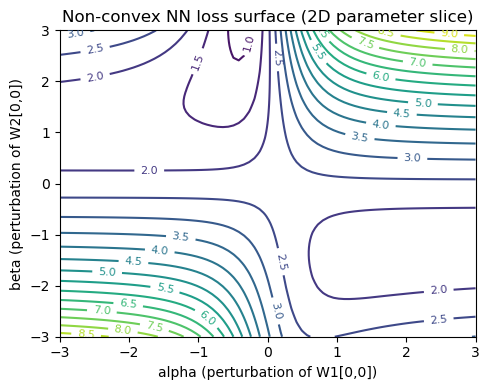

Saved figure: figs/nonconvex_nn_loss_contours.png


In [6]:
# 5. Non-convex loss surface slice for NN:
# vary a 2D subspace of parameters: (alpha, beta) perturbations
# of W1[0,0] and W2[0,0] around initialization.

alpha_vals = np.linspace(-3.0, 3.0, 80)
beta_vals = np.linspace(-3.0, 3.0, 80)
A_grid, B_grid = np.meshgrid(alpha_vals, beta_vals)
loss_nn_grid = np.zeros_like(A_grid)

for i in range(A_grid.shape[0]):
    for j in range(A_grid.shape[1]):
        alpha = A_grid[i, j]
        beta = B_grid[i, j]

        W1 = W1_init.copy()
        W2 = W2_init.copy()
        W1[0, 0] = W1_init[0, 0] + alpha
        W2[0, 0] = W2_init[0, 0] + beta

        params = (W1, b1_init, W2, b2_init)
        loss_nn_grid[i, j] = mse_loss_nn(params, x, y)

plt.figure(figsize=(5, 4))
cs = plt.contour(A_grid, B_grid, loss_nn_grid, levels=20)
plt.clabel(cs, inline=True, fontsize=8)
plt.xlabel("alpha (perturbation of W1[0,0])")
plt.ylabel("beta (perturbation of W2[0,0])")
plt.title("Non-convex NN loss surface (2D parameter slice)")
plt.tight_layout()
plt.savefig("figs/nonconvex_nn_loss_contours.png", dpi=200)
plt.show()

print("Saved figure: figs/nonconvex_nn_loss_contours.png")

## Exercise: Gradient Descent Trajectories

This notebook is designed to support the discussion in the *Convex Optimization – Primer* section of the book.
So far, you have:

- Constructed a **convex quadratic loss** (least-squares linear regression in 2D) and visualized its level sets.
- Constructed a **non-convex loss surface** for a tiny one-hidden-layer neural network by slicing a 2D subspace of parameters.
- Compared the contour plots of these two landscapes via the saved figures:
  - `figs/convex_quadratic_loss_contours.png`
  - `figs/nonconvex_nn_loss_contours.png`

To deepen your geometric intuition about optimization, extend this notebook as follows.

### Task 1: Gradient Descent on the Convex Quadratic

1. Implement vanilla gradient descent on the convex quadratic loss used above (linear regression in 2D).
2. Choose several different initial points in parameter space and run gradient descent for each.
3. On top of the contour plot
   `figs/convex_quadratic_loss_contours.png`,
   overlay the gradient descent **trajectories** as line plots in parameter space.
4. Observe how all trajectories converge smoothly to the *same* global minimizer.

### Task 2: Gradient Descent on the Non-Convex NN Loss

1. Reuse the tiny neural network defined in this notebook.
2. Implement gradient descent (or a simple optimizer like SGD) on the **full parameter vector**.
3. At each iteration, project the current parameter vector onto the
   2D slice used in `alpha`/`beta` (perturbations of `W1[0,0]` and `W2[0,0]`)
   and record the corresponding `(alpha, beta)` coordinates.
4. Overlay the resulting optimization path on top of the non-convex contour plot
   `figs/nonconvex_nn_loss_contours.png`.

Compare the convex and non-convex cases:
- How do the trajectories behave near valleys and plateaus?
- Can you observe regions where gradients are very small, leading to slow progress?
- Do different initializations converge to different minima in the non-convex case?

### Task 3: Experiment with Learning Rates and Noise

- Vary the learning rate and observe how it changes the optimization paths.
- Add small random noise to the gradient (mimicking stochastic gradient descent) and see how this affects
  escape from shallow minima or saddle points.

These experiments will give you a concrete, visual understanding of how convexity (or lack thereof)
shapes the behavior of gradient-based optimization algorithms.
